This notebook simulates polar arcing star trails and tries to find the center of the circle using the Hough transform.  The purpose is to determine if this method can be used with the Rubin-Obs-Simonyi telescope pointing verification with the Rubin StarTracker. 

In [61]:
%matplotlib inline
%autosave 60

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import random
import numpy.linalg as la
import pandas as pd
import plotly.express as px

from astropy.io import fits
from matplotlib.gridspec import GridSpec
from scipy.stats import sigmaclip
from scipy.ndimage import gaussian_filter
from skimage.transform import hough_circle
from skimage.transform import hough_circle_peaks
from skimage import measure

Autosaving every 60 seconds


In [3]:
# Colors (B, G, R)
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)

In [83]:
#create a working array for the arc image
height = 2472
width= 3294

In [5]:
# Ellipse parameters
center = (width // 2), (height // 2)
angle = 0
thickness = 2

In [6]:
print("True center:", center)

True center: (1647, 1236)


In [108]:
# http://docs.opencv.org/modules/core/doc/drawing_functions.html#ellipse
# Create multiple arcs with random radii and positions

arcImg = np.zeros((height, width), np.uint16)

arcNum = 25
arcCount = 0
arcLength = 90

for i in range(arcCount, arcNum):
    radius = random.randint(10, 2000) # Change range of radii depending image size
    print(radius)
    axes = (radius, radius) # Ellipse axes are the same to make a circle
    
    arcOffset = random.randint(0, 360) # This will randomly rotate the arc

    startAngle = arcOffset
    endAngle = arcLength + arcOffset

    arcImg = cv.ellipse(arcImg, center, axes, angle, startAngle, endAngle, WHITE, thickness)


165
330
242
1645
1154
1904
1672
1337
662
915
203
1883
943
143
1675
1146
1233
1555
24
1980
1423
1444
1059
1060
571


In [109]:
sigma = (1, 1)
arcImg = gaussian_filter(arcImg, sigma=sigma)

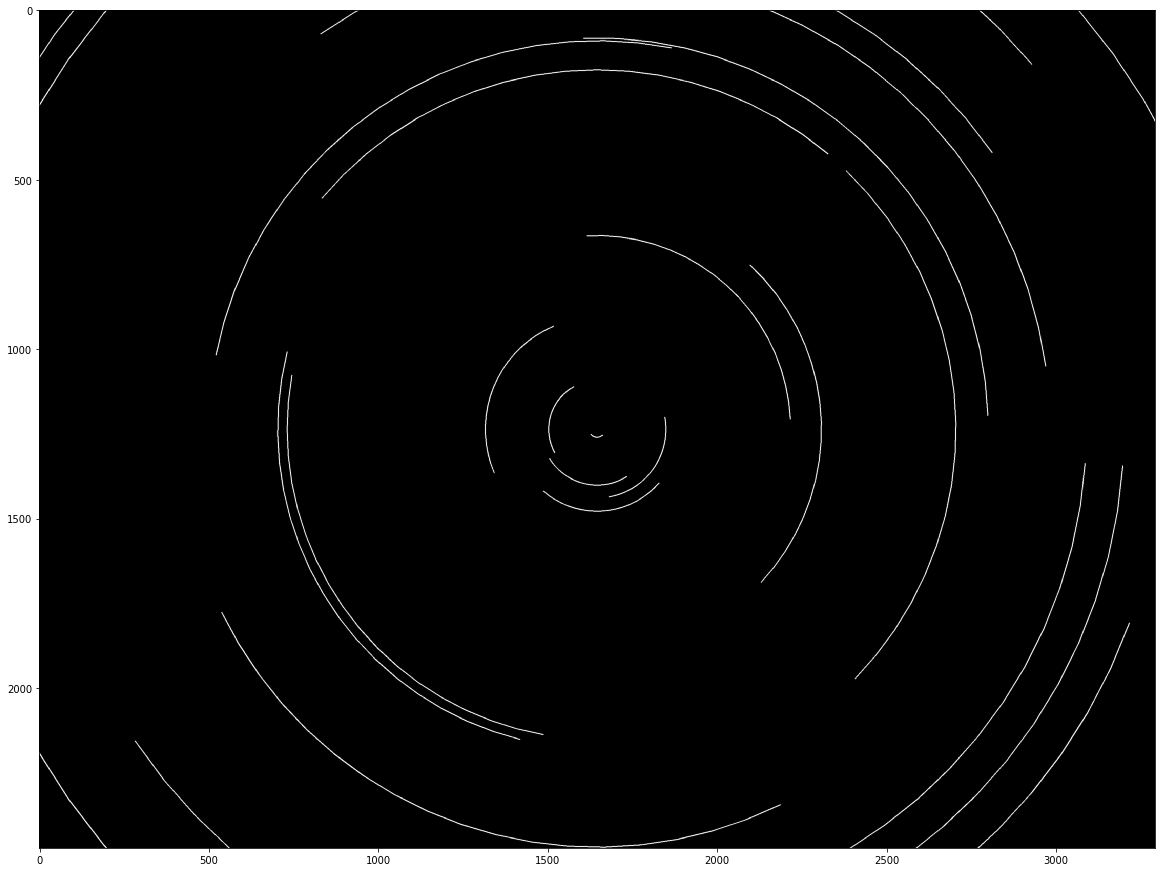

In [110]:
plt.figure(figsize=(20,20))
plt.imshow(arcImg, cmap = 'gray', interpolation = 'none')
#plt.xlim(1100, 1200)
#plt.ylim(600, 700)
plt.show()

8.149925179168348e-14


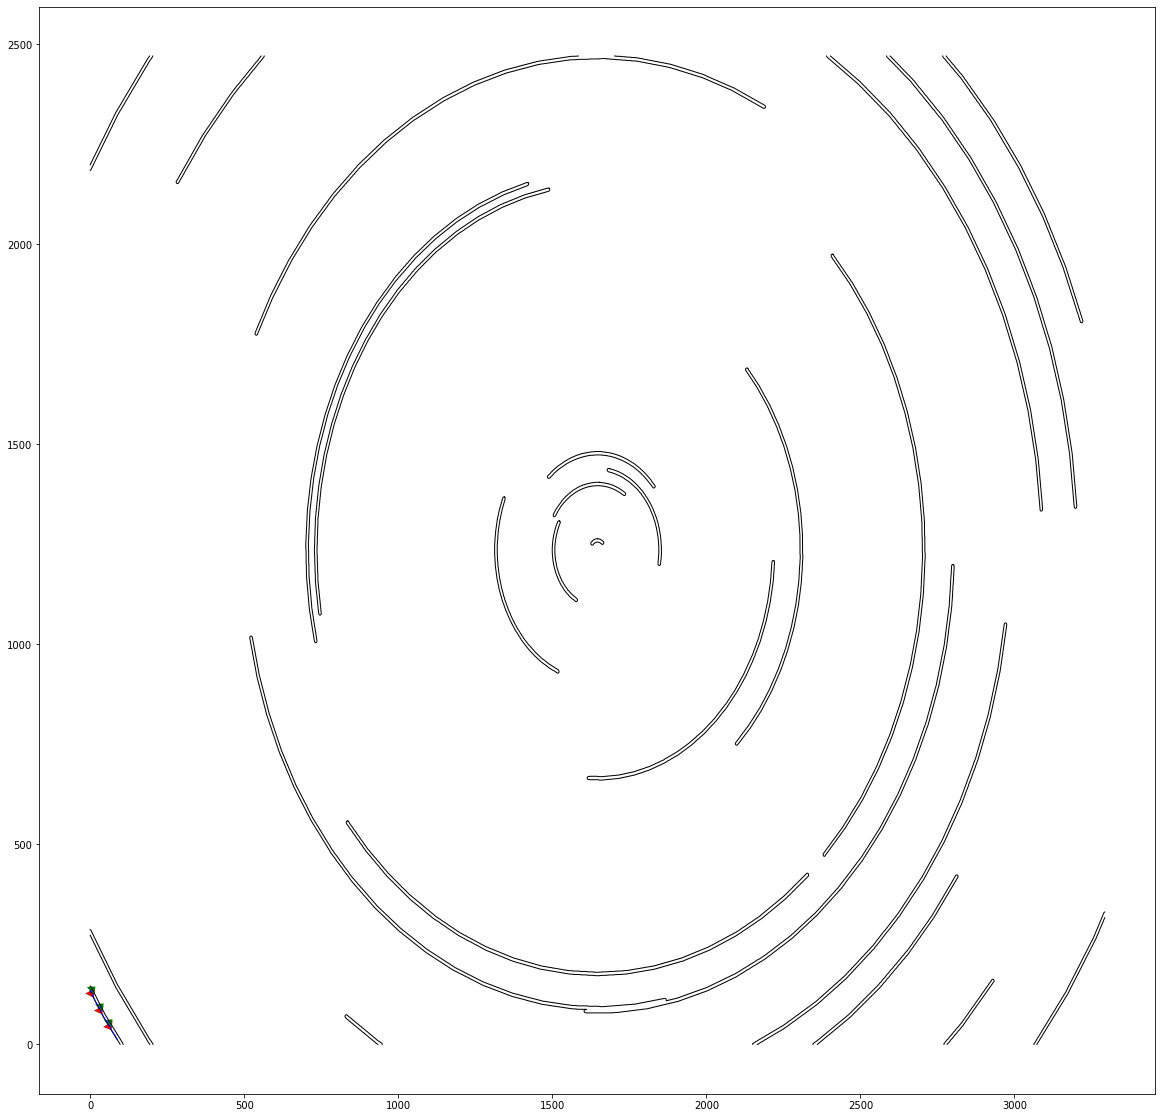

In [112]:
contours = measure.find_contours(arcImg, 0.7)
plt.figure(figsize=(20,20))
cNum = 0

for icontour, contour in enumerate(contours):
    if icontour != cNum:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=1, color='k')
        
step = 70
cxy = np.flip(contours[cNum][::step], axis=1)
vt = cxy[1:] - cxy[:-1]
vn = vt[1:] - vt[:-1]

plt.plot(contours[cNum][:, 1], contours[cNum][:,0], linewidth=1, color='k')
plt.plot(cxy[:, 0], cxy[:, 1], linewidth=1, color='b')


R90 = np.array([[0, -1], [1, 0]])
vt = vt.transpose()
vtNorms = la.norm(vt, axis=0)
vtNormsClipped, l, u = sigmaclip(vtNorms, low=3, high=3)

normals = np.matmul(R90, vt)
print(np.matmul(normals[:, 0], vt[:, 0]))

vtNorms = la.norm(vt, axis=0)
vtNormsClipped, l, u = sigmaclip(vtNorms, low=2.5, high=2.5)
vtGoodIdx = np.in1d(vtNorms, vtNormsClipped)

x = cxy[:-1].transpose()[0]#[vtGoodIdx]
y = cxy[:-1].transpose()[1]#[vtGoodIdx]

dx = vt[0]#[vtGoodIdx]
dy = vt[1]#[vtGoodIdx]

#dx2 = vn.transpose()[0]
#dy2 = vn.transpose()[1]
nx = normals[0]#[vtGoodIdx]
ny = normals[1]#[vtGoodIdx]

idx = np.argmax(vtNorms)

plt.quiver(x, y, dx, dy, color='r', scale_units='xy', scale=2.5, angles='xy',
           headaxislength=2, headwidth=3, headlength=2, width=0.004)

plt.quiver(x, y, nx, ny, color='g', scale_units='xy', scale=2.5, angles='xy',
           headaxislength=2, headwidth=3, headlength=2, width=0.004)

plt.show()

1502.6072080144652


/home/adriansh/notebooks/jupyterenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in true_divide



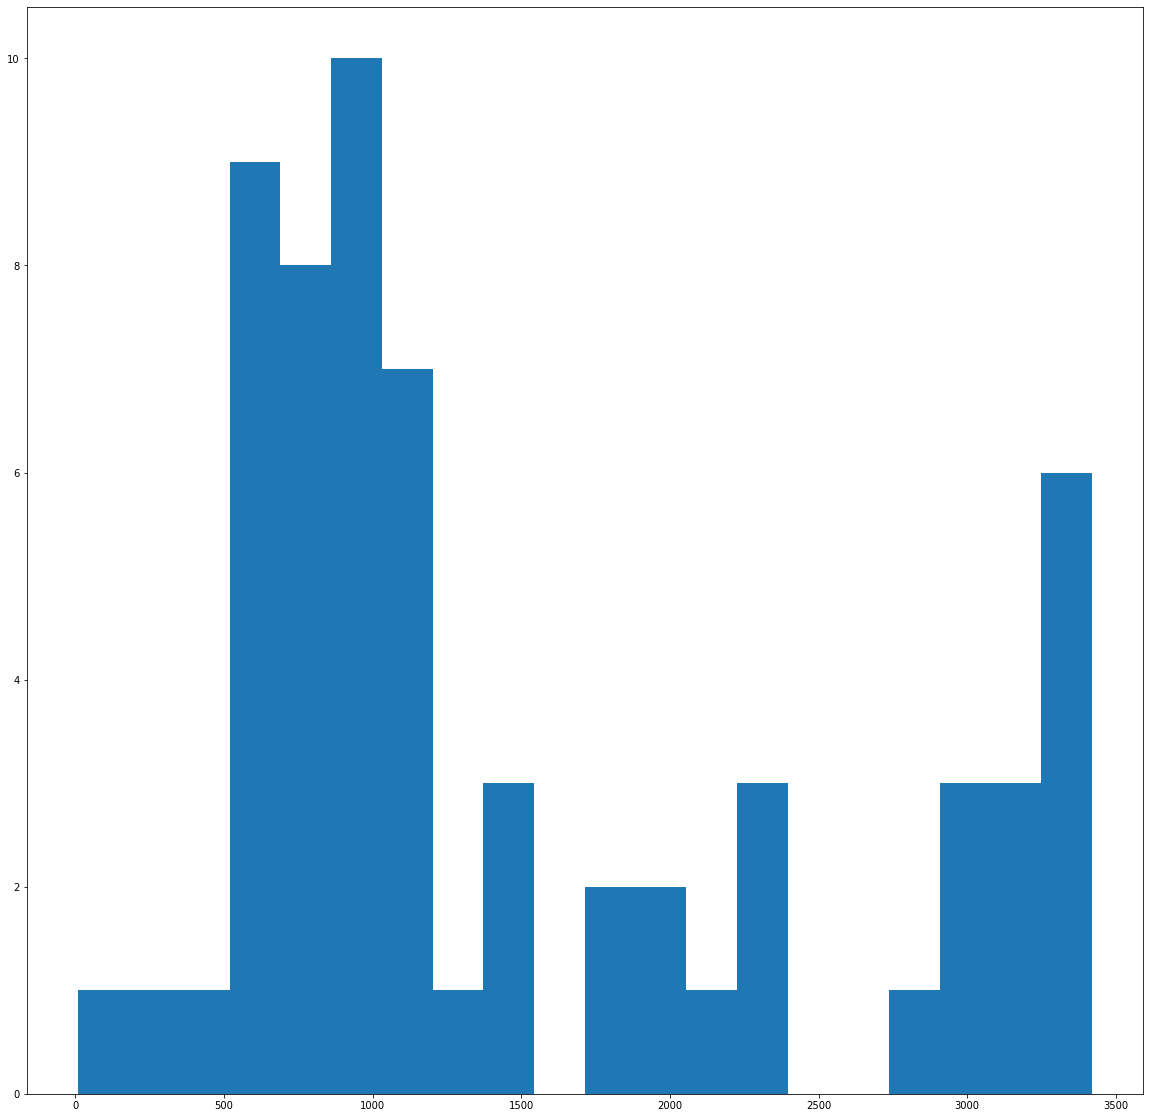

In [60]:
theta = np.arctan2(dy, dx)
dTheta = np.abs(theta[1:] - theta[:-1])
dSdTh = vtNorms[:-1]/dTheta

dThdSClipped, l, h = sigmaclip(dThdS, low=3, high=3)
dSdThClipped, l, h = sigmaclip(dSdTh[np.isfinite(dSdTh)], low=2, high=2)
print(dSdThClipped.mean())

fig = plt.figure(figsize=(20, 20))
plt.hist(dSdThClipped, bins=20)
plt.show()

[0.00242733 0.00878362 0.00341923 0.01218245 0.         0.00689251
 0.00344626 0.00242733 0.00878362 0.00242733 0.00878362 0.00242733
 0.00485467 0.00769401 0.00485467 0.00769401 0.00242733 0.01378503
 0.00242733 0.0108895  0.00485467 0.00769401 0.00544475 0.01033877
 0.00344626 0.01033877 0.00689251 0.01378503 0.00487374 0.01242565
 0.00344626 0.01378503 0.00878362 0.00769401 0.00544475 0.01033877
 0.07411863 0.19747344 0.00242733 0.01218245 0.00341923 0.0156021
 0.00344626 0.01378503 0.00770606 0.00770606 0.01378503 0.00344626
 0.01378503 0.00344626 0.01378503 0.         0.01033877 0.00344626
 0.00689251 0.00544475 0.00485467 0.00878362 0.         0.01033877
 0.00242733 0.0108895  0.00242733 0.00544475 0.00544475 0.00242733
 0.00769401 0.00242733 0.01033877 0.         0.00544475 0.00769401
 0.00242733 0.01033877]


/home/adriansh/notebooks/jupyterenv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

divide by zero encountered in true_divide

/home/adriansh/notebooks/jupyterenv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in true_divide



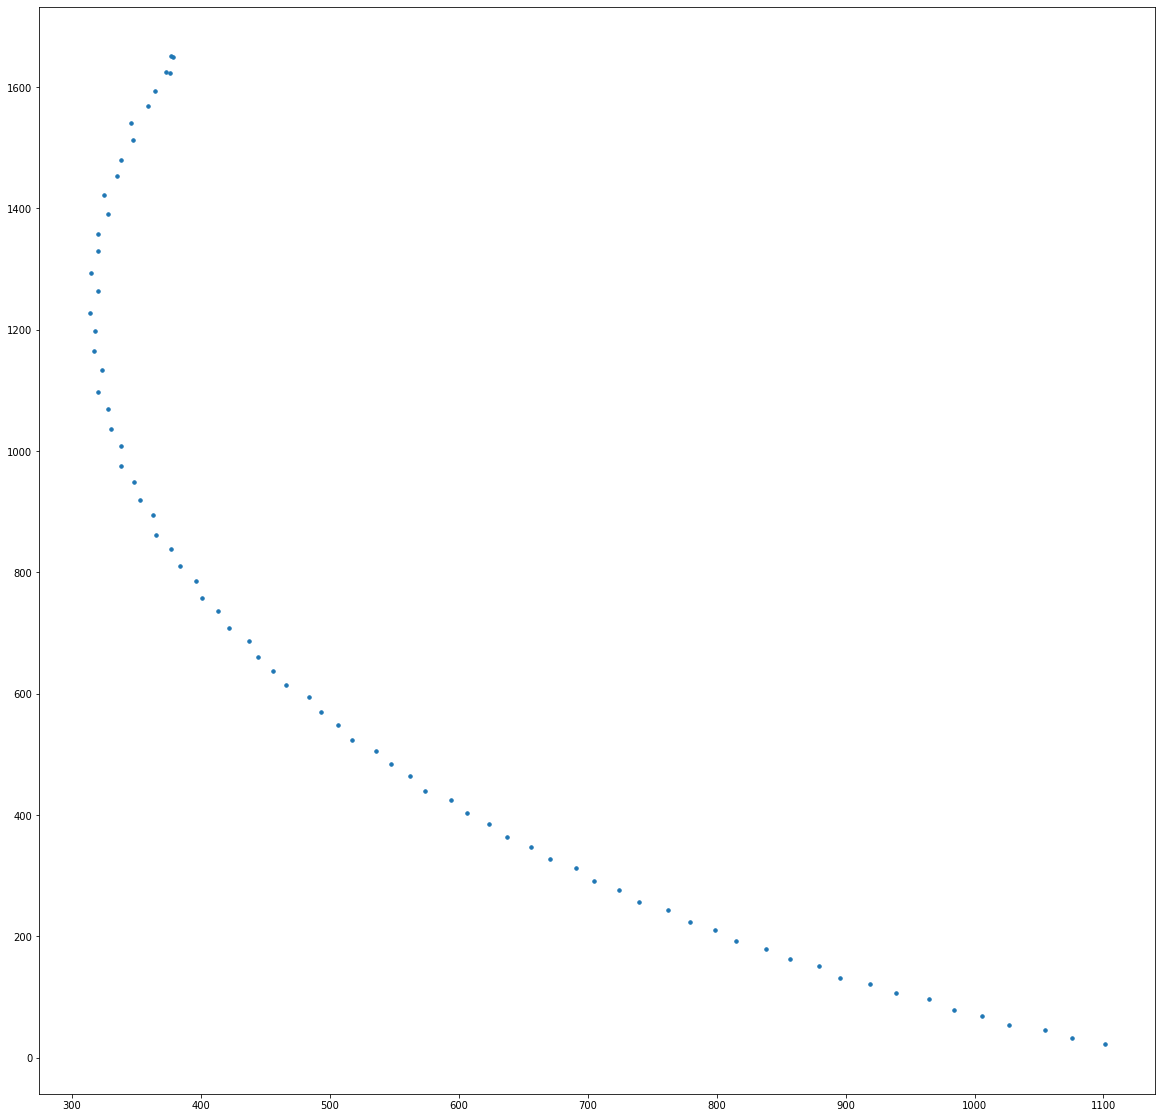

In [19]:
vtNorms = la.norm(vt, axis=1)
vnNorms = la.norm(vn, axis=1)
lam = vnNorms / vtNorms[1:]

r = vtNorms[1:] / lam
vn_rescaled = vn.transpose() / lam**2
vn_rescaled = vn_rescaled.transpose()
centers = cxy[1:-1] + vn
df = pd.DataFrame(centers, columns=['x_centers', 'y_centers'])
#print(df)
xCenters = centers[:, 0]
yCenters = centers[:, 1]

fig = plt.figure(figsize=(20,20))
plt.scatter(centers[:, 0], centers[:, 1], s=12)
plt.show()


In [ ]:
fig = px.density_heatmap(df, marginal_x='histogram', marginal_y='histogram', 
                        nbinsx=50, nbinsy=50)
fig.show()

In [122]:
lam = vnNorms / vtNorms[1:]
r = vtNorms[1:] / lam
print(lam, r)

72
[[-28.99607843 -31.99607843]
 [-28.         -32.        ]
 [-26.         -34.        ]
 [-26.         -34.        ]
 [-24.         -36.        ]
 [-22.00392157 -37.00392157]
 [-21.99607843 -38.99607843]
 [-20.         -40.        ]
 [-19.         -41.        ]
 [-17.         -43.        ]]
[43.18010652 42.52058325 42.80186912 42.80186912 43.26661531 43.05186147
 44.77188403 44.72135955 45.18849411 46.23851209]
[0.99608615 2.82842712 0.         2.82842712 2.23432039 1.9921723
 2.23432039 1.41421356 2.82842712 1.41421356]
[0.02342598 0.06608186 0.         0.06537205 0.05189835 0.04449606
 0.04996092 0.03129588 0.06117038 0.0302061  0.05882353 0.0571662
 0.04467334 0.05983359 0.06634115 0.07432941 0.05452203 0.05540187
 0.06515435 0.0601701  0.09954733 0.01974667 0.09481039 0.02099934
 0.06117038 0.04847467 0.0720285  0.02248782 0.06492275 0.03268602
 0.0328798  0.0514689  0.04757498 0.07319864 0.02346494 2.02848495
 0.074436   0.05335771 0.04589087 0.05194689 0.03268602 0.03246137
 0.

/home/adriansh/notebooks/jupyterenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


In [ ]:
print(vtNorms[:10])
print(vnNorms[:10])
lam = vnNorms / vtNorms[1:]
r = vtNorms[1:] / lam
print(lam, r)

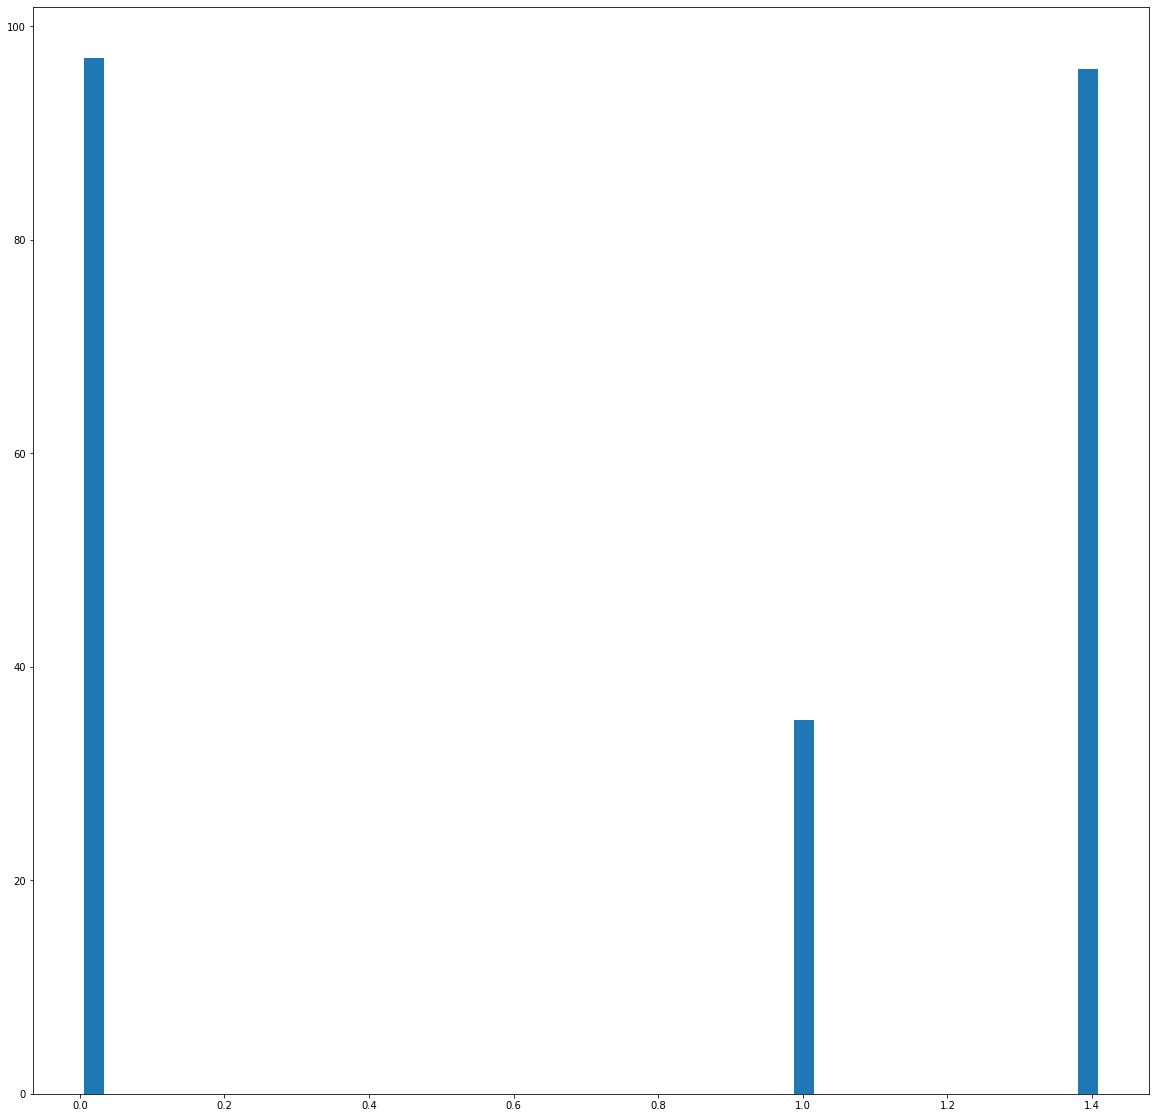

In [89]:
plt.figure(figsize=(20,20))
plt.hist(vtNorms, bins=50)
plt.show()

In [116]:
def make_canvas(arcImg):
    canvas = np.zeros(tuple(3*np.array(arcImg.shape)), np.uint16)
    binImg = make_binary_image(arcImg)
    canvas[arcImg.shape[0]:2*arcImg.shape[0], arcImg.shape[1]:2*arcImg.shape[1]] += binImg
    
    return canvas

def rotate_and_paint_image(img, x, y):
    xyBright = np.flip(np.array(np.where(binImg > 0))) # Flip to put x on top to make things easier to think about
    origin = np.vstack([x, y])
    r = xyBright - origin
    
    for nDeg in range(1, 361):
        theta = np.pi * nDeg / 180
        rotM = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        rPrime = np.matmul(rotM, r)
        xyPrime = np.round(origin + rPrime)
        xyPrime = xyPrime.astype(int)
        

In [121]:
def make_binary_image(arcImg, threshold=0.75):
    a = np.ones(arcImg.shape)
    binImg = np.where(arcImg > threshold, a, 0*a)
    return binImg

In [143]:
binImg = make_binary_image(arcImg)
yBright, xBright = np.array(np.where(binImg > 0)) # This is (row, column), so (y, x)
xyBright = np.vstack([xBright, yBright])
print(xyBright, np.flip(np.array(np.where(binImg > 0)), axis=0))
nDeg = 1
theta = np.pi * nDeg / 180 #degrees
RotM = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
rotImg = np.matmul(RotM, xyBright)
rotImgInt = rotImg.astype(int)
print(xyBright)
print(rotImg)
print(rotImgInt)

[[  98   99  100 ... 2776 2777 2778]
 [   0    0    0 ... 2471 2471 2471]] [[  98   99  100 ... 2776 2777 2778]
 [   0    0    0 ... 2471 2471 2471]]
[[  98   99  100 ... 2776 2777 2778]
 [   0    0    0 ... 2471 2471 2471]]
[[9.79850741e+01 9.89849218e+01 9.99847695e+01 ... 2.73245231e+03
  2.73345215e+03 2.73445200e+03]
 [1.71033583e+00 1.72778824e+00 1.74524064e+00 ... 2.51907154e+03
  2.51908899e+03 2.51910644e+03]]
[[  97   98   99 ... 2732 2733 2734]
 [   1    1    1 ... 2519 2519 2519]]


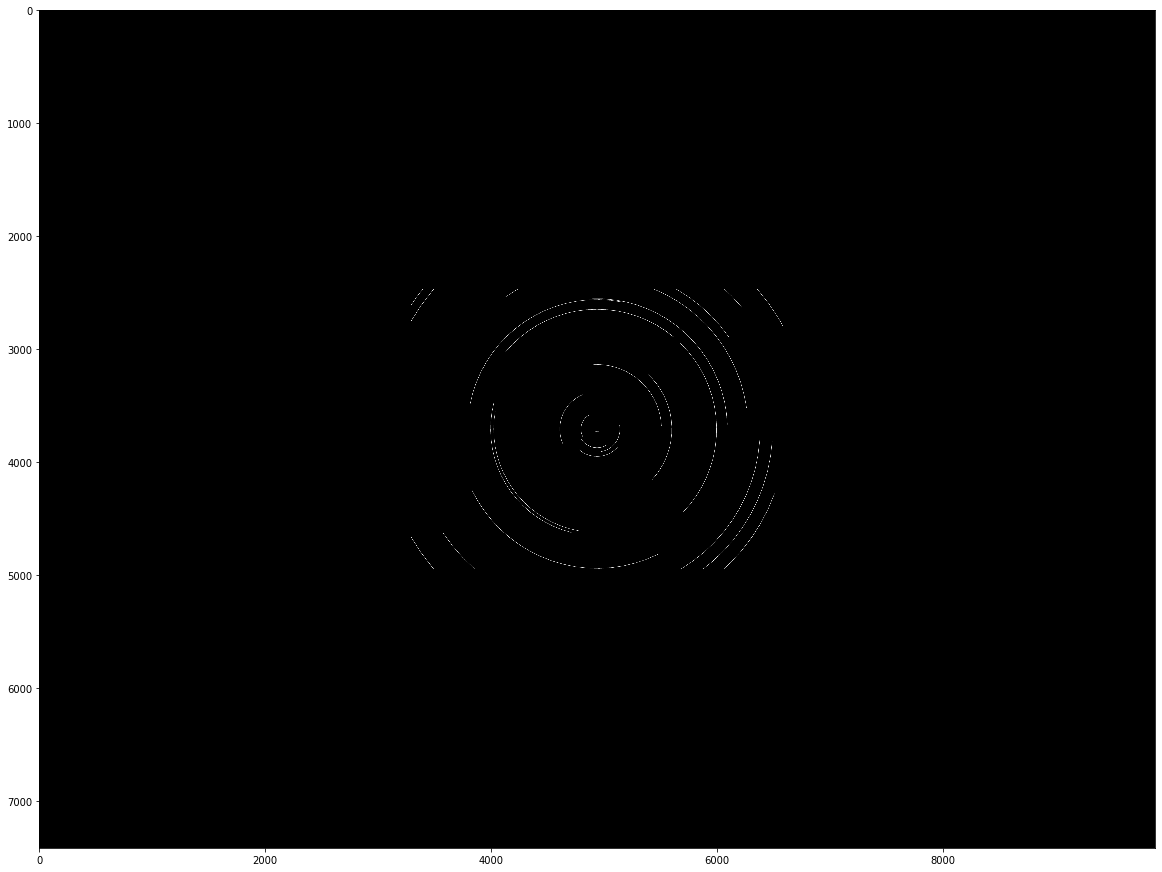

In [117]:
canvas = make_canvas(arcImg)

plt.figure(figsize=(20,20))
plt.imshow(canvas, cmap = 'gray', interpolation = 'none')
plt.show()

In [547]:
try_radii = np.arange(250, 1000)
res = hough_circle(arcImg, try_radii)
# ridx, r, c = np.unravel_index(np.argmax(res), res.shape)

In [551]:
accums, cx, cy, radii = hough_circle_peaks(res, try_radii, total_num_peaks=100)

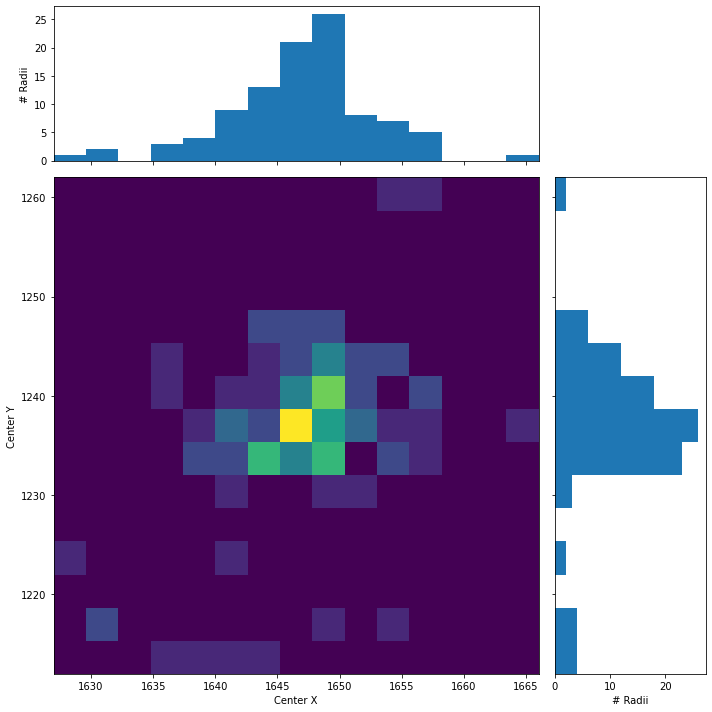

In [556]:
fig = plt.figure(figsize=(10,10))

gs = GridSpec(4, 4, figure=fig)

numBins = 15

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3], sharex = ax_joint)
ax_marg_y = fig.add_subplot(gs[1:4,3], sharey = ax_joint)


ax_joint.hist2d(cx,cy, bins=numBins)
ax_marg_x.hist(cx, bins=numBins)
ax_marg_y.hist(cy, bins=numBins, orientation="horizontal")

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Center X')
ax_joint.set_ylabel('Center Y')

# Set labels on marginals
ax_marg_y.set_xlabel('# Radii')
ax_marg_x.set_ylabel('# Radii')

plt.tight_layout()
plt.show()


In [557]:
cx.mean(), cy.mean()

(1646.85, 1236.28)

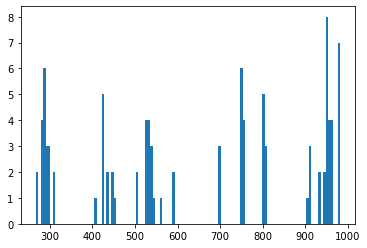

In [558]:
r_hist = plt.hist(radii, bins=125)

In [261]:
hdu = fits.PrimaryHDU()
hdu.data = arcImg
hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3294                                                  
NAXIS2  =                 2472                                                  
EXTEND  =                    T                                                  
BSCALE  =                    1                                                  
BZERO   =                32768                                                  

In [7]:
hdu.writeto('test2.fits')